In [2]:
import os
from scipy.io import wavfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc

import pickle
from keras.callbacks import ModelCheckpoint
from cfg import Config

In [3]:
AUDIO_FOLDER = 'clean/'

In [4]:
df = pd.read_csv('./instuments.csv')
df.set_index('Filename', inplace=True)

In [5]:
for f in df.index:
    rate, signal = wavfile.read(f'{AUDIO_FOLDER}{f}')
    df.at[f, 'length'] = signal.shape[0] / rate

In [6]:
# Extract unique classes from the 'Instrument' column in DataFrame df
classes = list(np.unique(df['Instrument']))

# Calculate the mean length of audio for each class and store it in class_dist
class_dist = df.groupby(['Instrument'])['Length'].mean()

In [7]:
n_samples = 2 * int(df['Length'].sum()/0.1)
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

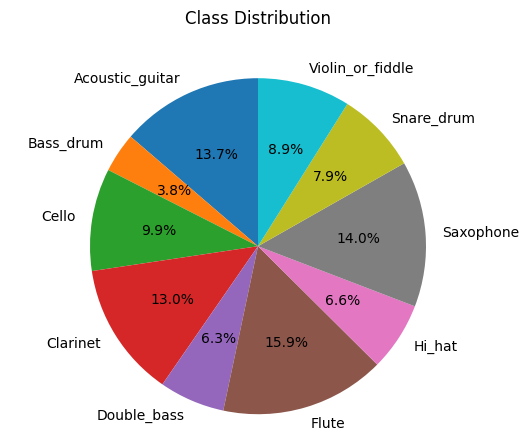

In [8]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%', shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [10]:
def check_data():
    if os.path.isfile(config.p_path):
        print("Loading existing data for {} model".format(config.mode))
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

In [11]:
def build_rand_feat():
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]

    X = []
    y = []

    _min, _max = float('inf'), -float('inf')

    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p=prob_dist)
        file = np.random.choice(df[df.Instrument==rand_class].index)
        rate, signal = wavfile.read(f'{AUDIO_FOLDER}{file}')
        label = df.at[file, 'Instrument']
        rand_index = np.random.randint(0, signal.shape[0] - config.step)
        sample = signal[rand_index:rand_index+config.step]
        X_sample = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft)

        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)


        X.append(X_sample)
        y.append(classes.index(label))

    config.min = _min
    config.max = _max

    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)

    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

    y = to_categorical(y, num_classes=10)
    config.data = (X, y)

    with open(config.p_path, 'wb') as handle:
        pickle.dump(config, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return X, y

In [12]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(Conv2D(128, (3, 3), activation='relu', strides=(1, 1), padding='same', input_shape=input_shape))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    return model

In [13]:
def get_recurrent_model():
    # Shape of data for RNN is (n, time, feat)
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

    return model

In [25]:
config = Config(mode='conv')

if config.mode == 'conv':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()

elif config.mode == 'time':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()

Loading existing data for conv model
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 9, 13, 16)         160       
                                                                 
 conv2d_5 (Conv2D)           (None, 9, 13, 32)         4640      
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 13, 64)         18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 9, 13, 128)        73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 6, 128)         0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 4, 6, 128)         0         
                 

In [26]:
class_weight = compute_class_weight('balanced', classes=np.unique(y_flat), y=y_flat)
class_weight = dict(zip(np.unique(y_flat), class_weight))

In [27]:
checkpoint = ModelCheckpoint(config.model_path, monitor='val_acc', verbose=1, mode='max', save_best_only=True, save_weights_only=False, period=1)

In [28]:
model.fit(X, y, epochs=10, batch_size=32, shuffle=True, class_weight=class_weight, validation_split=0.1, callbacks=[checkpoint])
model.save(config.model_path)

Epoch 1/10
857/857 [==============================] - ETA: 0s - loss: 0.9647 - acc: 0.6386
Epoch 1: val_acc improved from -inf to 0.80591, saving model to models/conv.model
INFO:tensorflow:Assets written to: models/conv.model/assets


INFO:tensorflow:Assets written to: models/conv.model/assets


857/857 [==============================] - 11s 12ms/step - loss: 0.9647 - acc: 0.6386 - val_loss: 0.5569 - val_acc: 0.8059
Epoch 2/10
855/857 [============================>.] - ETA: 0s - loss: 0.4486 - acc: 0.8339
Epoch 2: val_acc improved from 0.80591 to 0.88473, saving model to models/conv.model
INFO:tensorflow:Assets written to: models/conv.model/assets


INFO:tensorflow:Assets written to: models/conv.model/assets


857/857 [==============================] - 13s 16ms/step - loss: 0.4484 - acc: 0.8340 - val_loss: 0.3522 - val_acc: 0.8847
Epoch 3/10
857/857 [==============================] - ETA: 0s - loss: 0.3190 - acc: 0.8814
Epoch 3: val_acc improved from 0.88473 to 0.91658, saving model to models/conv.model
INFO:tensorflow:Assets written to: models/conv.model/assets


INFO:tensorflow:Assets written to: models/conv.model/assets


857/857 [==============================] - 16s 18ms/step - loss: 0.3190 - acc: 0.8814 - val_loss: 0.2742 - val_acc: 0.9166
Epoch 4/10
855/857 [============================>.] - ETA: 0s - loss: 0.2516 - acc: 0.9065
Epoch 4: val_acc did not improve from 0.91658
857/857 [==============================] - 15s 18ms/step - loss: 0.2514 - acc: 0.9065 - val_loss: 0.2378 - val_acc: 0.9156
Epoch 5/10
854/857 [============================>.] - ETA: 0s - loss: 0.2147 - acc: 0.9196
Epoch 5: val_acc improved from 0.91658 to 0.94581, saving model to models/conv.model
INFO:tensorflow:Assets written to: models/conv.model/assets


INFO:tensorflow:Assets written to: models/conv.model/assets


857/857 [==============================] - 16s 18ms/step - loss: 0.2148 - acc: 0.9196 - val_loss: 0.1704 - val_acc: 0.9458
Epoch 6/10
854/857 [============================>.] - ETA: 0s - loss: 0.1860 - acc: 0.9311
Epoch 6: val_acc improved from 0.94581 to 0.95238, saving model to models/conv.model
INFO:tensorflow:Assets written to: models/conv.model/assets


INFO:tensorflow:Assets written to: models/conv.model/assets


857/857 [==============================] - 16s 18ms/step - loss: 0.1858 - acc: 0.9312 - val_loss: 0.1616 - val_acc: 0.9524
Epoch 7/10
854/857 [============================>.] - ETA: 0s - loss: 0.1629 - acc: 0.9391
Epoch 7: val_acc improved from 0.95238 to 0.95369, saving model to models/conv.model
INFO:tensorflow:Assets written to: models/conv.model/assets


INFO:tensorflow:Assets written to: models/conv.model/assets


857/857 [==============================] - 16s 18ms/step - loss: 0.1630 - acc: 0.9391 - val_loss: 0.1474 - val_acc: 0.9537
Epoch 8/10
857/857 [==============================] - ETA: 0s - loss: 0.1546 - acc: 0.9428
Epoch 8: val_acc improved from 0.95369 to 0.96092, saving model to models/conv.model
INFO:tensorflow:Assets written to: models/conv.model/assets


INFO:tensorflow:Assets written to: models/conv.model/assets


857/857 [==============================] - 16s 18ms/step - loss: 0.1546 - acc: 0.9428 - val_loss: 0.1178 - val_acc: 0.9609
Epoch 9/10
855/857 [============================>.] - ETA: 0s - loss: 0.1353 - acc: 0.9498
Epoch 9: val_acc did not improve from 0.96092
857/857 [==============================] - 15s 18ms/step - loss: 0.1358 - acc: 0.9497 - val_loss: 0.1512 - val_acc: 0.9507
Epoch 10/10
855/857 [============================>.] - ETA: 0s - loss: 0.1195 - acc: 0.9553
Epoch 10: val_acc did not improve from 0.96092
857/857 [==============================] - 15s 18ms/step - loss: 0.1197 - acc: 0.9552 - val_loss: 0.1306 - val_acc: 0.9570
INFO:tensorflow:Assets written to: models/conv.model/assets


INFO:tensorflow:Assets written to: models/conv.model/assets
